# Imports 

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import swifter
import scipy.stats as sps
import plotly.express as px
pd.set_option('max_columns', None)
from tqdm.notebook import tqdm
from itertools import product
from soccer_xg import XGModel, DataApi, xg
from fuzzywuzzy import fuzz
from unidecode import unidecode
import regex as re
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
import pickle
from statistics import median

In [3]:
#pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_rows", 3000)

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Data 

## Generate xG for PL 17-18 

In [756]:
provider = 'wyscout_opensource'
leagues = ['ENG', 'ESP', 'ITA', 'GER', 'FRA']
seasons = ['1718']
api = DataApi([
    f"../data/vaep/h5_files/spadl-{provider}-{l}-{s}.h5"
    for (l, s) in product(leagues, seasons)
])

In [757]:
#load pre-trained model
xg_model = xg.XGModel.load_model(
    f'openplay_xgboost_advanced')  # custom pipeline for open play shots

In [758]:
xg_model.train(api, training_seasons=[('ENG', '1718'), ('ESP', '1718'), ('ITA', '1718'), ('FRA', '1718'), ('GER', '1718')])

Generating labels: 100%|██████████████████████████████████████████████████████████████████████████| 1826/1826 [00:54<00:00, 33.67it/s]


Generating features: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [02:13<00:00,  2.84it/s]
No handles with labels found to put in legend.


{'max_dev': 17.198703619756884,
 'residual_area': 485.9176859010821,
 'roc': 0.8360929262465635,
 'brier': 0.07624689231692355,
 'ece': 0.0124419481637788,
 'ace': 0.011993946697342099,
 'fig': <Figure size 720x360 with 3 Axes>}

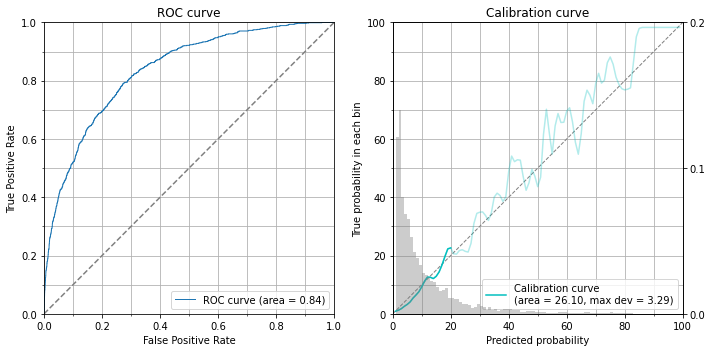

In [759]:
xg_model.validate(api, validation_seasons=[('ENG', '1718')])

In [760]:
df_games = pd.read_hdf(
    'C:/Users/Anuj/Desktop/Work/Football/VAEP/fot-valuing-actions-master/notebooks/spadl.h5',
    key='games')
df_games.head()

game_id  competition_id  season_id            game_date  home_team_id  \
0  2500089             364     181150  2018-05-13 14:00:00          1646   
1  2500090             364     181150  2018-05-13 14:00:00          1628   
2  2500091             364     181150  2018-05-13 14:00:00          1673   
3  2500092             364     181150  2018-05-13 14:00:00          1612   
4  2500093             364     181150  2018-05-13 14:00:00          1611   

   away_team_id  
0          1659  
1          1627  
2          1609  
3          1651  
4          1644

In [761]:
# # predict xG values
xg_pl = xg_model.estimate(api, game_ids=list(df_games[df_games['competition_id']==364]['game_id'].values))

Generating features: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [02:13<00:00,  2.84it/s]


In [55]:
xg_pl.to_pickle('../data/vaep/xG_pl.pkl')

In [762]:
xg_pl

xG
game_id action_id          
2500089 276        0.101725
        314        0.037059
        368        0.057251
        374        0.039816
        401        0.057477
...                     ...
2499719 1149       0.049527
        1157       0.267522
        1184       0.093349
        1187       0.103965
        1286       0.026161

[8451 rows x 1 columns]

In [880]:
xg_pl = pd.read_pickle('../data/vaep/xG_pl.pkl')

## Compute xG vs off_value per defender for optimal action window   

In [8]:
vaep = pd.read_pickle('../data/vaep/vaep_values.pkl')
player = pd.read_pickle('../data/players/players.pkl')
match_def = pd.read_pickle('../data/matches/match+def_lineup+footedness_ver2.pkl')
uni = pd.read_pickle('../data/defender_clusters/defender_attrs_def_region_wise.pkl')
xg_pl = pd.read_pickle('../data/vaep/xG_pl.pkl')

In [10]:
vaep = vaep.replace({'short_team_name':{
        'Brighton & Hove Albion': 'Brighton and Hove Albion'
    }}
)

vaep['full_name'] = vaep['first_name']+vaep['last_name']
vaep['full_name'] = vaep['full_name'].astype(str).apply(lambda x: unidecode(x))
vaep['full_name'] = vaep['full_name'].apply(lambda x: x.replace('-', ''))
vaep['full_name'] = vaep['full_name'].apply(lambda x: x.replace(' ', ''))

In [11]:
def match_names(name, l):
    tatb = ['RCB', 'CB', 'LCB']
    fatb = ['RB', 'R_CB', 'L_CB', 'LB']
    fiatb = ['RWB', 'RCB', 'CB', 'LCB', 'LWB']
    player_map = {  'RamiroFunesMori': 'JoseRamiroFunesMori',
                'KurtZouma': 'KurtHappyZouma',
                'Danilo': 'DaniloLuizdaSilva',
                'CesarAzpilicueta': 'CesarAzpilicuetaTanco',
                'EzequielSchelotto': 'MatiasEzequielSchelotto',
                'GaetanBong': 'GaetanBongSongo',
                'HectorBellerin': 'HectorBellerinMoruno',
                'AhmedHegazi': 'AhmedHegazy',
                'JamaalLascelles': 'JamalLascelles',
                'AngelRangel': 'AngelRangelZaragoza',
                'Zanka': 'MathiasJattahNjieJorgensen',
                'EricBailly': 'EricBertrandBailly',
                'MarcosRojo': 'FaustinoMarcosAlbertoRojo',
                'AngeloOgbonna': 'AngeloObinzeOgbonna',
                'DavinsonSanchez': 'DavinsonSanchezMina',
                'JavierManquillo': 'JavierManquilloGaitan',
                'TommySmith': 'TomSmith',
                'Bruno': 'BrunoSaltorGrau',
                'JosephGomez': 'JoeGomez',
                'AlbertoMoreno':'AlbertoMorenoPerez',
                'LuisAntonioValencia':'LuisAntonioValenciaMosquera',
                'NicolasOtamendi':'NicolasHernanOtamendi',
                'NachoMonreal':'IgnacioMonrealEraso',
                'CedricSoares':'CedricRicardoAlvesSoares',
                'JoelMatip':'JoelAndreJobMatip',
                'MiguelBritos':'MiguelAngelBritosCabrera',
                'VictorLindelof':'VictorNilssonLindelof',
                'JamesCollins':'JamesMichaelCollins',
                'CucoMartina':'RhuendlyMartina',
                'DavidLuiz':'DavidLuizMoreiraMarinho',
                'ChancelMbemba':'ChancelMbembaMangulu',
                'PabloZabaleta':'PabloJavierZabaletaGirod',
                'KikoFemenia':'FranciscoFemeniaFar',
                'JoseFonte':'JoseMigueldaRochaFonte',
                'JesusGamez':'JesusGamezDuarte'}

    res = []
    for i in range(len(l)):
        try:
            l[i] = player_map[l[i]]
        except:
            pass
        split_player = re.findall('[A-Z][^A-Z]*', l[i])
        if((split_player[-1] in name)==True):
            if(len(l)==3):
                res = [tatb[i], l[i]]
                break
            elif(len(l)==4):
                res = [fatb[i], l[i]]
                break
            elif(len(l)==5):
                res = [fiatb[i], l[i]]
                break
        elif((split_player[-1] in name)==False):
            res = ['not', l[i]]
    
    return res

In [12]:
def compute_xG_vs_offval(cutoff_xg, n):
    df = pd.DataFrame(columns=[
        'player_name', 'position', 'match_id', 'team', 'off_val_opp', 'num',
        'denom'
    ])
    cutoff_xg_pl = xg_pl[xg_pl['xG'] >= cutoff_xg]

    for i in tqdm(cutoff_xg_pl.index):
        a = vaep[vaep['game_id'] == i[0]].reset_index(drop=True)
        opp_team = a.loc[i[1]]['short_team_name']
        try:
            cand = list(a.loc[(i[1] - n):i[1]]['full_name'].values)
            cand = [(cand[k], (i[1] - n + k)) for k in range(len(cand))
                    if (a[a['full_name'] == cand[k]]
                        ['short_team_name'].values[0] == opp_team)
                    & (player[player['playerName'] == cand[k]]
                       ['role'].values[0]['code3'] == 'DEF')
                    & (a.loc[(i[1] - n + k)]['type_name'] == 'pass')]

            for j in range(len(cand)):
                def_line = match_def[(match_def['wyId'] == i[0]) & (
                    match_def['team'] == opp_team)]['team_defense']
                res = match_names(cand[j][0], def_line.values[0])
                if (res[0] != 'not'):
                    num = a.loc[cand[j][1]]['offensive_value']
                    denom = a.loc[(i[1] - n):i[1]]['offensive_value'].sum()
                    off_val_opp = (num) / (denom)
                    row = {
                        'player_name': res[1],
                        'position': res[0],
                        'match_id': i[0],
                        'team': opp_team,
                        'off_val_opp': off_val_opp,
                        'num': num,
                        'denom': denom
                    }
                    df = df.append(row, ignore_index=True)
                else:
                    continue
        except:
            pass
    return df

(0, 0.5)

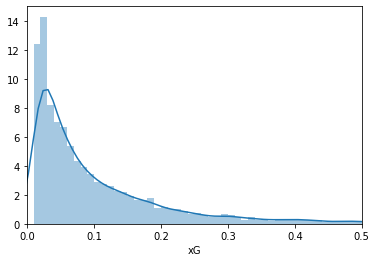

In [13]:
ax = sns.distplot(xg_pl['xG'], kde=True, hist=True, hist_kws={"range": [0,0.5]})
ax.set_xlim(0, 0.5)

In [14]:
off_val_opp_df = compute_xG_vs_offval(0.25, 5)

In [15]:
off_val_opp_df.head()

player_name position match_id               team  off_val_opp  \
0          MamadouSakho     L_CB  2500090     Crystal Palace     0.002151   
1    FlorentHadergjonaj      RWB  2500091  Huddersfield Town    -0.359458   
2       ShkodranMustafi     R_CB  2500091            Arsenal    -3.473009   
3            RobHolding     L_CB  2500091            Arsenal     0.021364   
4  TrentAlexanderArnold       RB  2500092          Liverpool     0.038857   

        num     denom  
0  0.002132  0.991345  
1  0.012915 -0.035928  
2  0.142943 -0.041158  
3  0.000651  0.030465  
4  0.037971  0.977210

In [16]:
off_val_opp_df['position'].value_counts()

RB      100
L_CB     75
LB       75
R_CB     74
LCB      37
CB       26
RCB      24
LWB       4
RWB       3
Name: position, dtype: int64

In [17]:
df = off_val_opp_df

In [18]:
df_scale = df[['num', 'denom']]
df_scale = pd.DataFrame(MinMaxScaler().fit_transform(df_scale), columns = ['num', 'denom'])

In [19]:
df['off_val_opp'] = df_scale['num']/df_scale['denom']

In [20]:
df1 = pd.DataFrame(
    df.groupby([
        'player_name',
        'position',
        'team',
        'match_id',
    ])['off_val_opp'].mean()).reset_index()

df1 = pd.DataFrame(
    df1.groupby(['player_name', 'position',
                 'team'])['off_val_opp'].sum()).reset_index()

In [21]:
def avg_cmp(x):
    matches_played = uni[(uni['player_name'] == x.player_name) & (uni['position'] == x.position) & (uni['team'] == x.team)]['matches_played']
    if float(matches_played)>2:
        return float(x['off_val_opp'])/float(matches_played)
    else:
        return np.nan

In [22]:
df1['off_val_opp'] = df1.apply(lambda x:avg_cmp(x),
                               axis=1)

In [23]:
df = pd.DataFrame(
    df.groupby(['player_name', 'position', 'team'
                            ])['off_val_opp'].sum()).reset_index()

In [24]:
df['off_val_opp_avg'] = df1['off_val_opp']
df.columns = ['player_name', 'position', 'team', 'off_val_opp_sum', 'off_val_opp_avg']

In [25]:
df.head()

player_name position             team  off_val_opp_sum  off_val_opp_avg
0   AaronCresswell       LB  West Ham United         0.183867         0.026267
1   AaronCresswell      LCB  West Ham United         4.509658         0.154344
2  AaronWanBissaka       RB   Crystal Palace         1.627672         0.232525
3        AdamSmith       LB  AFC Bournemouth         1.456683         0.485561
4   AdrianMariappa       RB          Watford         1.411601         0.470534

In [26]:
len(df)

158

In [27]:
len(df[df['off_val_opp_avg'].notnull()])

141

# Viz 

In [28]:
df2 = df[df['position'].str.contains('CB')].reset_index(drop=True)

In [29]:
df2 = df2[df2['player_name']!='MikevanderHoorn']

In [30]:
df2 = df2[df2['off_val_opp_avg'].notnull()]

In [31]:
len(df2)

79

In [32]:
df2.sort_values(by=['off_val_opp_avg'], ascending=False)

player_name position                      team  \
77             ShkodranMustafi     R_CB                   Arsenal   
83       VictorNilssonLindelof     R_CB         Manchester United   
63       NicolasHernanOtamendi     L_CB           Manchester City   
72                   ScottDann     R_CB            Crystal Palace   
86               VirgilvanDijk     L_CB               Southampton   
82            TobyAlderweireld     R_CB         Tottenham Hotspur   
80           TimothyFosuMensah      RCB            Crystal Palace   
58                 MayaYoshida     R_CB               Southampton   
69               RyanShawcross       CB                Stoke City   
84              VincentKompany     R_CB           Manchester City   
9               AntonioRudiger      LCB                   Chelsea   
68                  RobHolding     L_CB                   Arsenal   
56  MathiasJattahNjieJorgensen     R_CB         Huddersfield Town   
81           TimothyFosuMensah     R_CB            Crystal Palace   
4           AleksandarDragovic     R_CB            Leicester City   
18               ChrisSmalling     L_CB         Manchester United   
85               VirgilvanDijk     L_CB                 Liverpool   
7           AndreasChristensen       CB                   Chelsea   
43           JoelAndreJobMatip     R_CB                 Liverpool   
16       CesarAzpilicuetaTanco      RCB                   Chelsea   
20           ChristianKabasele       CB                   Watford   
44                  JohnStones     R_CB           Manchester City   
31              FlorianLejeune     L_CB          Newcastle United   
65              PerMertesacker       CB                   Arsenal   
74                  ShaneDuffy     R_CB  Brighton and Hove Albion   
59    MiguelAngelBritosCabrera      LCB                   Watford   
12              AymericLaporte     L_CB           Manchester City   
46                  JonnyEvans     L_CB      West Bromwich Albion   
90                 WinstonReid       CB           West Ham United   
41               JanVertonghen      LCB         Tottenham Hotspur   
37              JamalLascelles     R_CB          Newcastle United   
64       NicolasHernanOtamendi     R_CB           Manchester City   
33                  GaryCahill      LCB                   Chelsea   
17               ChrisSmalling       CB         Manchester United   
30           FedericoFernandez       CB              Swansea City   
34                GeoffCameron      LCB                Stoke City   
36         IgnacioMonrealEraso      LCB                   Arsenal   
3                  AhmedHegazy     R_CB      West Bromwich Albion   
35                HarryMaguire     L_CB            Leicester City   
71                   ScottDann     L_CB            Crystal Palace   
24     DavidLuizMoreiraMarinho       CB                   Chelsea   
32                  GaryCahill       CB                   Chelsea   
0               AaronCresswell      LCB           West Ham United   
61                   NathanAke      LCB           AFC Bournemouth   
25         DavinsonSanchezMina     R_CB         Tottenham Hotspur   
5                  AlfieMawson      LCB              Swansea City   
78                   SteveCook       CB           AFC Bournemouth   
38         JamesMichaelCollins      RCB           West Ham United   
47      JoseMigueldaRochaFonte      RCB           West Ham United   
27                 DejanLovren     R_CB                 Liverpool   
55                MamadouSakho     L_CB            Crystal Palace   
11              AshleyWilliams     L_CB                   Everton   
52            LaurentKoscielny      RCB                   Arsenal   
67                RagnarKlavan     L_CB                 Liverpool   
22                 CiaranClark     L_CB          Newcastle United   
48                   KevinLong     R_CB                   Burnley   
79                   SteveCook     R_CB           AFC Bournemouth   
13               

In [33]:
df2.sort_values(by=['off_val_opp_sum'], ascending=False)

player_name position                      team  \
63       NicolasHernanOtamendi     L_CB           Manchester City   
16       CesarAzpilicuetaTanco      RCB                   Chelsea   
56  MathiasJattahNjieJorgensen     R_CB         Huddersfield Town   
74                  ShaneDuffy     R_CB  Brighton and Hove Albion   
77             ShkodranMustafi     R_CB                   Arsenal   
9               AntonioRudiger      LCB                   Chelsea   
7           AndreasChristensen       CB                   Chelsea   
84              VincentKompany     R_CB           Manchester City   
35                HarryMaguire     L_CB            Leicester City   
31              FlorianLejeune     L_CB          Newcastle United   
37              JamalLascelles     R_CB          Newcastle United   
43           JoelAndreJobMatip     R_CB                 Liverpool   
33                  GaryCahill      LCB                   Chelsea   
58                 MayaYoshida     R_CB               Southampton   
72                   ScottDann     R_CB            Crystal Palace   
36         IgnacioMonrealEraso      LCB                   Arsenal   
0               AaronCresswell      LCB           West Ham United   
69               RyanShawcross       CB                Stoke City   
86               VirgilvanDijk     L_CB               Southampton   
5                  AlfieMawson      LCB              Swansea City   
30           FedericoFernandez       CB              Swansea City   
85               VirgilvanDijk     L_CB                 Liverpool   
44                  JohnStones     R_CB           Manchester City   
54                   LewisDunk     L_CB  Brighton and Hove Albion   
46                  JonnyEvans     L_CB      West Bromwich Albion   
55                MamadouSakho     L_CB            Crystal Palace   
12              AymericLaporte     L_CB           Manchester City   
82            TobyAlderweireld     R_CB         Tottenham Hotspur   
83       VictorNilssonLindelof     R_CB         Manchester United   
25         DavinsonSanchezMina     R_CB         Tottenham Hotspur   
41               JanVertonghen      LCB         Tottenham Hotspur   
79                   SteveCook     R_CB           AFC Bournemouth   
27                 DejanLovren     R_CB                 Liverpool   
3                  AhmedHegazy     R_CB      West Bromwich Albion   
17               ChrisSmalling       CB         Manchester United   
4           AleksandarDragovic     R_CB            Leicester City   
13                      BenMee     L_CB                   Burnley   
64       NicolasHernanOtamendi     R_CB           Manchester City   
42               JanVertonghen     L_CB         Tottenham Hotspur   
67                RagnarKlavan     L_CB                 Liverpool   
22                 CiaranClark     L_CB          Newcastle United   
61                   NathanAke      LCB           AFC Bournemouth   
66                   PhilJones     L_CB         Manchester United   
48                   KevinLong     R_CB                   Burnley   
80           TimothyFosuMensah      RCB            Crystal Palace   
59    MiguelAngelBritosCabrera      LCB                   Watford   
24     DavidLuizMoreiraMarinho       CB                   Chelsea   
81           TimothyFosuMensah     R_CB            Crystal Palace   
20           ChristianKabasele       CB                   Watford   
34                GeoffCameron      LCB                Stoke City   
40              JamesTarkowski     R_CB                   Burnley   
70               RyanShawcross     R_CB                Stoke City   
90                 WinstonReid       CB           West Ham United   
18               ChrisSmalling     L_CB         Manchester United   
52            LaurentKoscielny      RCB                   Arsenal   
78                   SteveCook       CB           AFC Bournemouth   
19               ChrisSmalling     R_CB         Manchester United   
71               

In [34]:
print(df2['off_val_opp_avg'].max())
print(df2['off_val_opp_avg'].min())

0.9543998486981808
0.005331189077409748


In [35]:
print(df2['off_val_opp_sum'].max())
print(df2['off_val_opp_sum'].min())

19.254974518999546
0.1375130526545315


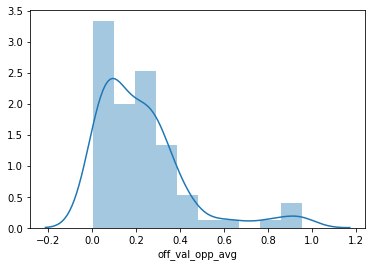

In [36]:
sns.distplot(df2['off_val_opp_avg'])

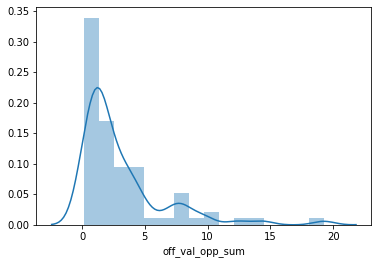

In [37]:
sns.distplot(df2['off_val_opp_sum'])

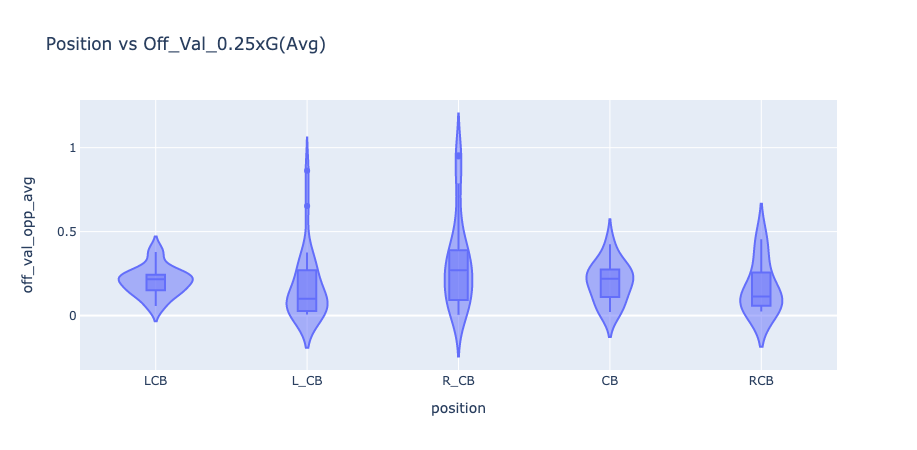

In [38]:
fig = px.violin(df2,
                x='position',
                y='off_val_opp_avg',
                title=r'Position vs Off_Val_0.25xG(Avg)',
                hover_data=['player_name'],
                box=True)
                #points='all')
fig.show()

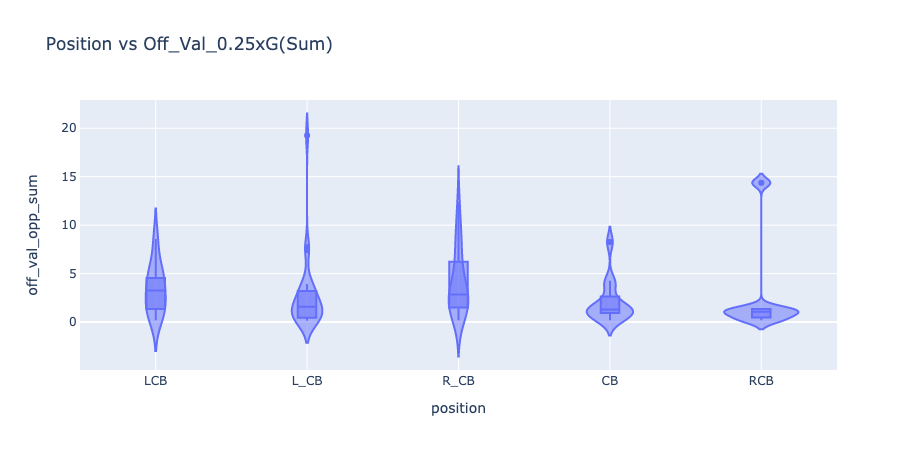

In [39]:
fig = px.violin(df2,
                x='position',
                y='off_val_opp_sum',
                title=r'Position vs Off_Val_0.25xG(Sum)',
                hover_data=['player_name'],
                box=True)
                #points='all')
fig.show()

# Merging with Player Metrics DF 

In [40]:
df.head()

player_name position             team  off_val_opp_sum  off_val_opp_avg
0   AaronCresswell       LB  West Ham United         0.183867         0.026267
1   AaronCresswell      LCB  West Ham United         4.509658         0.154344
2  AaronWanBissaka       RB   Crystal Palace         1.627672         0.232525
3        AdamSmith       LB  AFC Bournemouth         1.456683         0.485561
4   AdrianMariappa       RB          Watford         1.411601         0.470534

In [41]:
df['key'] = df['player_name'] + df['team'] + df['position']
uni['key'] = uni['player_name'] + uni['team'] + uni['position']

In [42]:
uni.columns

Index(['index', 'player_name', 'team', 'position', 'footedness',
       'matches_played', 'passes', 'accpass', 'progaccpass', 'proginaccpass',
       'accpassloc', 'inaccpassloc', 'progaccpassloc', 'proginaccpassloc',
       'accpassvaep', 'inaccpassvaep', 'progaccpassvaep', 'proginaccpassvaep',
       'accpassoff', 'inaccpassoff', 'progaccpassoff', 'proginaccpassoff',
       'accpassdef', 'inaccpassdef', 'progaccpassdef', 'proginaccpassdef',
       'progaccidx', 'proginaccidx', 'offsum_regionwise', 'vaepsum_regionwise',
       'prog_acc_region_per_pass', 'vaep_acc_region_per_pass',
       'prog_inacc_region_per_pass', 'vaep_inacc_region_per_pass',
       'off_acc_region_per_pass', 'off_inacc_region_per_pass',
       'def_acc_region_per_pass', 'def_inacc_region_per_pass',
       'vaep_avgcontri', 'vaep_stdcontri', 'off_avgcontri', 'off_stdcontri',
       'progpreference_per_region', 'progaccuracy_per_region',
       'total_off_region_per_pass', 'key'],
      dtype='object')

In [43]:
uni1 = uni.merge(df, left_on='key', right_on='key', how='left')
uni1.drop(columns=['key', 'player_name_y', 'position_y', 'team_y', 'index'], inplace=True)
uni1.columns = ['player_name', 'team', 'position', 'footedness',
       'matches_played', 'passes', 'accpass', 'progaccpass', 'proginaccpass',
       'accpassloc', 'inaccpassloc', 'progaccpassloc', 'proginaccpassloc',
       'accpassvaep', 'inaccpassvaep', 'progaccpassvaep', 'proginaccpassvaep',
       'accpassoff', 'inaccpassoff', 'progaccpassoff', 'proginaccpassoff',
       'accpassdef', 'inaccpassdef', 'progaccpassdef', 'proginaccpassdef',
       'progaccidx', 'proginaccidx', 'offsum_regionwise', 'vaepsum_regionwise',
       'prog_acc_region_per_pass', 'vaep_acc_region_per_pass',
       'prog_inacc_region_per_pass', 'vaep_inacc_region_per_pass',
       'off_acc_region_per_pass', 'off_inacc_region_per_pass',
       'def_acc_region_per_pass', 'def_inacc_region_per_pass',
       'vaep_avgcontri', 'vaep_stdcontri', 'off_avgcontri', 'off_stdcontri',
       'progpreference_per_region', 'progaccuracy_per_region',
       'total_off_region_per_pass', 'off_val_opp_sum', 'off_val_opp_avg']

In [44]:
uni1.head()

player_name             team position footedness  matches_played  \
0   AaronCresswell  West Ham United       LB       left             7.0   
1   AaronCresswell  West Ham United      LCB       left            20.0   
2  AaronWanBissaka   Crystal Palace       RB      right             7.0   
3        AdamSmith  AFC Bournemouth       LB      right             3.0   
4        AdamSmith  AFC Bournemouth       RB      right            10.0   

   passes  accpass  progaccpass  proginaccpass  \
0     275      203           43             47   
1     796      644          184             91   
2     226      165           39             20   
3     146      120           27             10   
4     451      387           71             35   

                                          accpassloc  \
0  [[[11.44, 47.6], [10.4, 48.96]], [[21.84, 58.4...   
1  [[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....   
2  [[[60.32, 11.56], [70.72, 8.84]], [[55.12, 11....   
3  [[[15.6, 59.84], [22.88, 54.4]], [[19.76, 61.2...   
4  [[[28.08, 4.76], [40.56, 20.4]], [[31.2, 13.6]...   

                                        inaccpassloc  \
0  [[[22.88, 65.28], [31.2, 63.24]], [[24.96, 61....   
1  [[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...   
2  [[[86.32, 22.44], [87.36, 25.84]], [[98.8, 10....   
3  [[[67.6, 13.6], [74.88, 33.32]], [[44.72, 2.72...   
4  [[[55.12, 4.08], [62.4, 6.8]], [[35.36, 4.08],...   

                                      progaccpassloc  \
0  [[[73.84, 66.64], [94.64, 63.92]], [[63.44, 55...   
1  [[[27.04, 51.68], [55.12, 64.6]], [[61.36, 59....   
2  [[[60.32, 11.56], [70.72, 8.84]], [[83.2, 12.9...   
3  [[[58.24, 53.04], [70.72, 62.56]], [[74.88, 41...   
4  [[[59.28, 6.12], [80.08, 6.8]], [[71.76, 4.76]...   

                                    proginaccpassloc  \
0  [[[24.96, 61.2], [49.92, 37.4]], [[40.56, 64.6...   
1  [[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...   
2  [[[30.16, 6.8], [70.72, 0.0]], [[57.2, 3.4], [...   
3  [[[67.6, 13.6], [74.88, 33.32]], [[44.72, 2.72...   
4  [[[35.36, 4.08], [79.04, 9.52]], [[55.12, 5.44...   

                                         accpassvaep  \
0  [-0.0060007767751812935, 0.014951384626328945,...   
1  [0.0010694738011807203, 0.002371369395405054, ...   
2  [0.0027392818592488766, -0.0019667267333716154...   
3  [-0.002463837619870901, -0.0001035716850310564...   
4  [0.0007454273290932178, -0.002337034558877349,...   

                                       inaccpassvaep  \
0  [-0.005001368001103401, 0.0014556727837771177,...   
1  [-0.00956201646476984, -0.007710381411015987, ...   
2  [-0.02877645380795002, -0.01624043844640255, -...   
3  [-0.007104361429810524, 1.648860052227974e-05,...   
4  [-0.008189908228814602, 0.0007318942807614803,...   

                                     progaccpassvaep  \
0  [0.010874261148273945, -0.0008622575551271439,...   
1  [0.0010694738011807203, 0.002284318208694458, ...   
2  [0.0027392818592488766, -0.011097729206085205,...   
3  [-0.0019909068942070007, -0.003893137909471988...   
4  [0.010347023606300354, 0.006110143847763538, 0...   

                                   proginaccpassvaep  \
0  [0.0014556727837771177, -0.004146812949329615,...   
1  [-0.00956201646476984, -0.007710381411015987, ...   
2  [-0.004570803605020046, -0.008917007595300674,...   
3  [-0.007104361429810524, 1.648860052227974e-05,...   
4  [0.0007318942807614803, -0.008694054558873177,...   

                                          accpassoff  \
0  [-0.00111871468834579, 0.0030969707295298576, ...   
1  [0.0018120664171874523, 0.002711281180381775, ...   
2  [0.002814173698425293, -0.0016991370357573032,...   
3  [-0.005229263566434383, 0.0009387347381561995,...   
4  [0.0013971277512609959, -0.0004184735007584095...   

                                        inaccpassoff  \
0  [-0.0018319590017199516, 0.0011951092164963484...   
1  [-0.006647953763604164, -0.006097717210650444,...   
2  [-0.027683690190315247, -0.01549511682242155, ...  

In [45]:
uni1.count()[-1]

141

In [981]:
uni1.to_pickle('../data/defender_clusters/defender_vectors.pkl')

## Profiling for best offensive contributors

In [46]:
df_defenders = uni1[uni1['off_val_opp_avg'].notnull()]

In [47]:
df_defenders[df_defenders['player_name'].str.contains("Danilo")]

player_name             team position footedness  matches_played  \
86  DaniloLuizdaSilva  Manchester City       LB      right             5.0   
87  DaniloLuizdaSilva  Manchester City       RB      right             6.0   

    passes  accpass  progaccpass  proginaccpass  \
86     313      287           73             15   
87     422      370          102             26   

                                           accpassloc  \
86  [[[47.84, 57.12], [23.92, 44.2]], [[27.04, 44....   
87  [[[59.28, 4.08], [68.64, 26.52]], [[58.24, 9.5...   

                                         inaccpassloc  \
86  [[[85.28, 51.0], [90.48, 35.36]], [[8.32, 62.5...   
87  [[[38.48, 10.88], [40.56, 6.8]], [[35.36, 10.2...   

                                       progaccpassloc  \
86  [[[58.24, 60.52], [74.88, 49.64]], [[68.64, 59...   
87  [[[59.28, 4.08], [68.64, 26.52]], [[58.24, 9.5...   

                                     proginaccpassloc  \
86  [[[85.28, 51.0], [90.48, 35.36]], [[8.32, 62.5...   
87  [[[57.2, 43.52], [67.6, 22.44]], [[62.4, 30.6]...   

                                          accpassvaep  \
86  [-0.0033419979736208916, -0.001290764892473816...   
87  [0.0038701544981449842, 0.0037723213899880648,...   

                                        inaccpassvaep  \
86  [-0.01568501628935337, -0.004935470409691334, ...   
87  [-0.001479479717090726, -0.002215859480202198,...   

                                      progaccpassvaep  \
86  [0.010689936578273773, 0.0029459535144269466, ...   
87  [0.0038701544981449842, 0.0037723213899880648,...   

                                    proginaccpassvaep  \
86  [-0.01568501628935337, -0.004935470409691334, ...   
87  [0.005961811635643244, -0.006980943027883768, ...   

                                           accpassoff  \
86  [-0.0034420606680214405, -0.001835872186347842...   
87  [0.004012984223663807, 0.003661242313683033, 0...   

                                         inaccpassoff  \
86  [-0.013578752987086773, 0.00030937022529542446...   
87  [7.367925718426704e-06, -0.000706125982105732,...   

                                       progaccpassoff  \
86  [0.010418041609227657, 0.0033841291442513466, ...   
87  [0.004012984223663807, 0.003661242313683033, 0...   

                                     proginaccpassoff  \
86  [-0.013578752987086773, 0.00030937022529542446...   
87  [0.0005987514741718769, -0.003778188955038786,...   

                                           accpassdef  \
86  [0.00010006269440054893, 0.0005451072938740253...   
87  [-0.00014282972551882267, 0.000111079076305031...   

                                         inaccpassdef  \
86  [-0.0021062633022665977, -0.005244840867817402...   
87  [-0.0014868476428091526, -0.001509733498096466...   

                                       progaccpassdef  \
86  [0.0002718950854614377, -0.0004381757462397218...   
87  [-0.00014282972551882267, 0.000111079076305031...   

                                     proginaccpassdef  \
86  [-0.0021062633022665977, -0.005244840867817402...   
87  [0.005363060161471367, -0.003202754072844982, ...   

                   progaccidx            proginaccidx  \
86       [18, 30, 38, 47, 73]       [3, 6, 6, 10, 15]   
87  [29, 48, 59, 83, 93, 102]  [4, 6, 11, 14, 18, 26]   

                                    offsum_regionwise  \
86  [-0.2997056695166975, 0.2532565104775131, 0.45...   
87  [0.36299721675459296, 0.6369351907633245, 0.55...   

                                   vaepsum_regionwise  \
86  [-0.3896409267326817, 0.2591369366273284, 0.42...   
87  [0.3222510248888284, 0.6021039230981842, 0.531...   

                           prog_acc_region_per_pass  \
86  [0, 1.37, 4.11, 1.37, 60.27, 21.92, 8.22, 2.74]   
87    [0.98, 0.98, 0, 0, 3.92, 14.71, 37.25, 42.16]   

                             vaep_acc_region_per_pass  \
86  [0, 6.312335841357708, 27.12922520004213, 7.07...   
87  [1.4174539828673005, 2.457591239362955, 0, 0, ...   

               

In [48]:
cols = ['player_name','team','position','footedness','matches_played','progaccpass','proginaccpass',
        'progpreference_per_region','progaccuracy_per_region','total_off_region_per_pass','off_avgcontri','off_val_opp_avg']

In [49]:
df_defenders_fil = df_defenders[cols]

In [50]:
df_defenders_fil.reset_index(inplace=True)

In [51]:
def get_ind_regions(df):
    df1 = pd.DataFrame(df['progpreference_per_region'].tolist(), columns = ['def_LF_pref','def_LC_pref','def_RC_pref','def_RF_pref','att_LF_pref','att_LC_pref','att_RC_pref','att_RF_pref'])
    df2 = pd.DataFrame(df['total_off_region_per_pass'].tolist(), columns = ['def_LF_off','def_LC_off','def_RC_off','def_RF_off','att_LF_off','att_LC_off','att_RC_off','att_RF_off'])
    df3 = pd.DataFrame(df['progaccuracy_per_region'].tolist(), columns = ['def_LF_acc','def_LC_acc','def_RC_acc','def_RF_acc','att_LF_acc','att_LC_acc','att_RC_acc','att_RF_acc'])
    df4 = pd.DataFrame(df['off_avgcontri'].tolist(), columns = ['att_LF_offcontri','att_LC_offcontri','att_RC_offcontri','att_RF_offcontri'])
    df = pd.concat([df,df1,df2,df3,df4], axis = 1)
    df.drop(['progpreference_per_region','total_off_region_per_pass','off_avgcontri','progaccuracy_per_region','index'], axis = 1, inplace = True)
    return df

In [52]:
df_defenders_ind = get_ind_regions(df_defenders_fil)

In [53]:
df_defenders_ind.head()

player_name             team position footedness  matches_played  \
0   AaronCresswell  West Ham United       LB       left             7.0   
1   AaronCresswell  West Ham United      LCB       left            20.0   
2  AaronWanBissaka   Crystal Palace       RB      right             7.0   
3        AdamSmith  AFC Bournemouth       LB      right             3.0   
4   AdrianMariappa          Watford       RB      right             3.0   

   progaccpass  proginaccpass  off_val_opp_avg  def_LF_pref  def_LC_pref  \
0           43             47         0.026267         1.11         3.33   
1          184             91         0.154344         1.82         1.09   
2           39             20         0.232525         1.69         1.69   
3           27             10         0.485561         0.00         0.00   
4           12             14         0.470534         0.00         7.69   

   def_RC_pref  def_RF_pref  att_LF_pref  att_LC_pref  att_RC_pref  \
0         1.11         1.11        44.44        30.00         6.67   
1         0.36         0.73        56.73        25.09         9.09   
2         1.69         3.39         3.39         6.78        16.95   
3         2.70         0.00        29.73        27.03        18.92   
4         3.85         7.69        11.54         7.69        19.23   

   att_RF_pref  def_LF_off  def_LC_off  def_RC_off  def_RF_off  att_LF_off  \
0        12.22    3.600341    1.969505    3.045104    7.787959    1.854026   
1         5.09    1.645727   -0.841284    1.703752    0.113256    4.098572   
2        64.41    0.574472    6.173175    7.698674    2.478837   -2.041411   
3        21.62    0.000000    0.000000    5.221050    0.000000    5.263003   
4        42.31    0.000000    2.560923    4.107819    3.532782   -0.266646   

   att_LC_off  att_RC_off  att_RF_off  def_LF_acc  def_LC_acc  def_RC_acc  \
0    2.507129   22.137616   -1.200041       100.0       33.33       100.0   
1   10.470576   19.408194    2.985546        60.0        0.00       100.0   
2   21.571248   36.222678    3.355633         0.0      100.00       100.0   
3    3.967432   17.062913    5.561234         0.0        0.00       100.0   
4    3.067968   -1.951540    1.824828         0.0       50.00       100.0   

   def_RF_acc  att_LF_acc  att_LC_acc  att_RC_acc  att_RF_acc  \
0       100.0       57.50       33.33       66.67       27.27   
1         0.0       78.21       52.17       60.00       50.00   
2        50.0       50.00       50.00       70.00       68.42   
3         0.0       90.91       50.00       57.14       87.50   
4       100.0       66.67        0.00       20.00       45.45   

   att_LF_offcontri  att_LC_offcontri  att_RC_offcontri  att_RF_offcontri  
0          0.949369          0.983086          0.757630          0.933282  
1          0.955638          0.787810          0.797654          0.757382  
2          0.934154          0.699378          0.804557          0.847289  
3          0.933989          0.678025          0.591580          0.944362  
4          0.933005          0.750674          0.751447          1.157488

In [54]:
df_defenders_ind_att = df_defenders_ind[[col for col in df_defenders_ind.columns if 'def' not in col]]

In [55]:
df_lb_ind = df_defenders_ind_att[df_defenders_ind_att['position']=='LB']

In [56]:
df_lb_ind.sort_values(by=['off_val_opp_avg'],ascending=False)

player_name                      team position footedness  \
39       DaniloLuizdaSilva           Manchester City       LB      right   
3                AdamSmith           AFC Bournemouth       LB      right   
38              DaleyBlind         Manchester United       LB       left   
90                LukeShaw         Manchester United       LB       left   
117          SeadKolasinac                   Arsenal       LB       left   
28          CharlieDaniels           AFC Bournemouth       LB       left   
69          JeffreySchlupp            Crystal Palace       LB       left   
22               BenDavies         Tottenham Hotspur       LB       left   
87          LeightonBaines                   Everton       LB       left   
29           CharlieTaylor                   Burnley       LB       left   
106            PaulDummett          Newcastle United       LB       left   
14         AndrewRobertson                 Liverpool       LB       left   
54         GaetanBongSongo  Brighton and Hove Albion       LB       left   
21             BenChilwell            Leicester City       LB       left   
110        RhuendlyMartina                   Everton       LB      right   
34          ChristianFuchs            Leicester City       LB       left   
112           RyanBertrand               Southampton       LB       left   
67   JavierManquilloGaitan          Newcastle United       LB      right   
19             AshleyYoung         Manchester United       LB      right   
30               ChrisLowe         Huddersfield Town       LB       left   
8       AlbertoMorenoPerez                 Liverpool       LB       left   
105      PatrickvanAanholt            Crystal Palace       LB       left   
77             JoseHolebas                   Watford       LB       left   
80             KieranGibbs      West Bromwich Albion       LB       left   
93            MartinOlsson              Swansea City       LB       left   
41               DannyRose         Tottenham Hotspur       LB       left   
0           AaronCresswell           West Ham United       LB       left   
126         TerenceKongolo         Huddersfield Town       LB       left   
92           MarkusSuttner  Brighton and Hove Albion       LB       left   
123            StephenWard                   Burnley       LB       left   

     matches_played  progaccpass  proginaccpass  off_val_opp_avg  att_LF_pref  \
39              5.0           73             15         4.506438        52.27   
3               3.0           27             10         0.485561        29.73   
38              3.0           42             15         0.456347        52.63   
90              7.0           68             24         0.412921        54.35   
117             8.0           43             25         0.394149        44.12   
28             21.0          178             94         0.287644        49.26   
69             12.0           92             43         0.257478        59.26   
22             20.0          217             96         0.224526        41.85   
87             16.0          142             61         0.211732        42.86   
29             10.0           63             41         0.153390        50.96   
106            16.0          108             63         0.135629        44.44   
14             21.0          289            123         0.133556        41.75   
54             25.0          148             94         0.132193        53.31   
21             17.0          127            114         0.129295        48.13   
110            14.0           91             50         0.119641        51.06   
34             20.0          165            121         0.101174        48.25   
112            26.0          258             99         0.099017        54.34   
67             12.0           62             35         0.090719        49.48   
19             21.0          239            115         0.082149        55.37   
30             14.0           85      

In [59]:
df_lb_ind_best = df_lb_ind[df_lb_ind['off_val_opp_avg']>=median(df_lb_ind['off_val_opp_avg'].tolist())]

In [60]:
df_lb_ind_best[df_lb_ind_best['player_name'].str.contains("Danilo")]

player_name             team position footedness  matches_played  \
39  DaniloLuizdaSilva  Manchester City       LB      right             5.0   

    progaccpass  proginaccpass  off_val_opp_avg  att_LF_pref  att_LC_pref  \
39           73             15         4.506438        52.27        30.68   

    att_RC_pref  att_RF_pref  att_LF_off  att_LC_off  att_RC_off  att_RF_off  \
39         7.95         3.41    5.473496    3.981862    2.801207   11.886917   

    att_LF_acc  att_LC_acc  att_RC_acc  att_RF_acc  att_LF_offcontri  \
39       95.65       59.26       85.71       66.67          1.011546   

    att_LC_offcontri  att_RC_offcontri  att_RF_offcontri  
39          0.699405           0.60888          1.193543

In [61]:
def get_plots(df):
    col_types = ['pref','acc','off','offcontri']
    df_cat = df[df.columns[:4]]
    df_name = df['player_name']
    df_vals = df[df.columns[8:]]
    for i in col_types:
        df_temp = df_vals[[col for col in df_vals.columns if i==col[len(col)-len(i):]]]
        df_temp_name = pd.concat([df_name,df_temp],axis=1)
        df_temp_melt = pd.melt(df_temp_name,id_vars=['player_name'],value_vars=df_temp.columns)
        df_temp_all = df_temp_melt.merge(df_cat,on=['player_name'])
        fig = px.box(df_temp_all, y="value", facet_col="variable", boxmode="overlay",color="footedness",points="all",hover_data=['player_name','team','footedness'])
#         for i in range(len(fig["data"])):
#             yaxis_name = 'yaxis' if i == 0 else f'yaxis{i + 1}'
#             fig.layout[yaxis_name].showticklabels = True

        fig.update_layout(legend = dict(bgcolor = 'white'))
        fig.update_layout(plot_bgcolor='white')

        fig.update_xaxes(showline=True, linewidth=2, linecolor='black')#, mirror=True)
        fig.update_yaxes(showline=True, linewidth=2, linecolor='black')#, mirror=True)

        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='gray')
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='gray')

        fig.show()

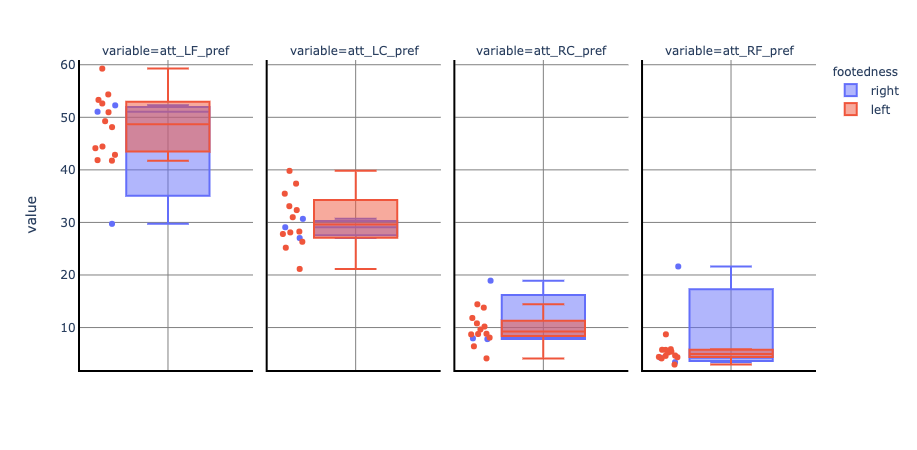

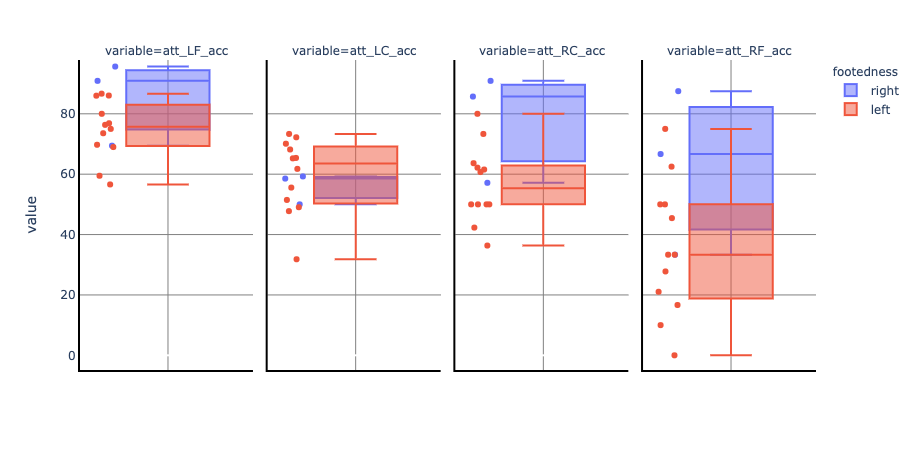

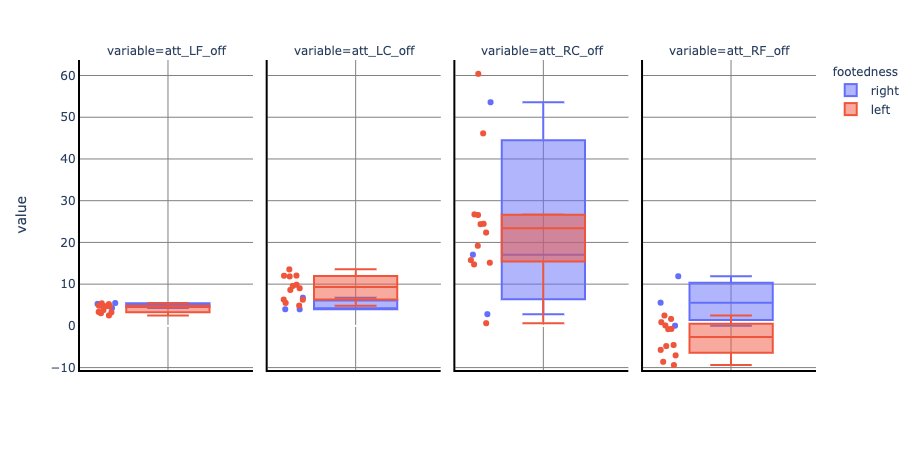

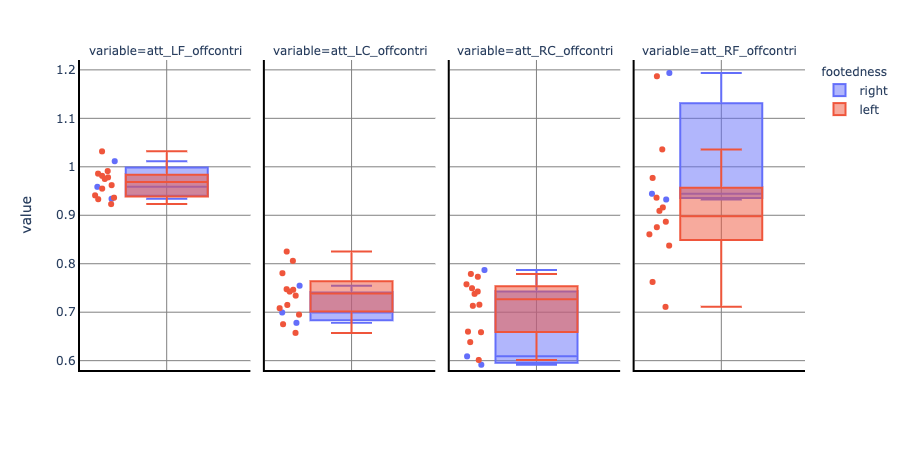

In [62]:
get_plots(df_lb_ind_best)

In [63]:
df_lcb_ind = df_defenders_ind_att[df_defenders_ind_att['position'].isin(['L_CB','LCB'])]

In [64]:
df_lcb_ind_best = df_lcb_ind[df_lcb_ind['off_val_opp_avg']>=median(df_lcb_ind['off_val_opp_avg'].tolist())]

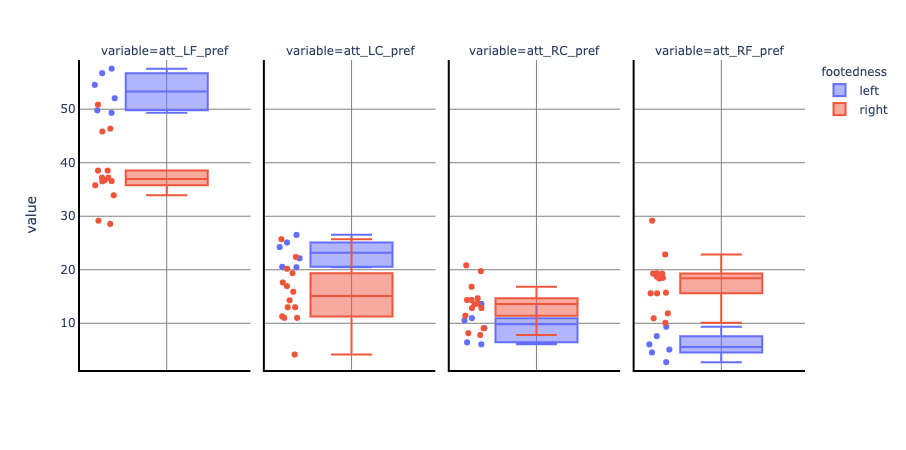

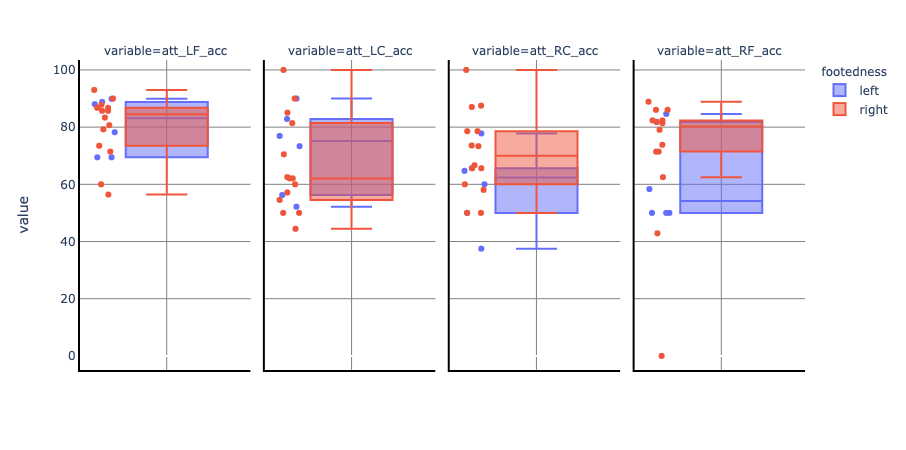

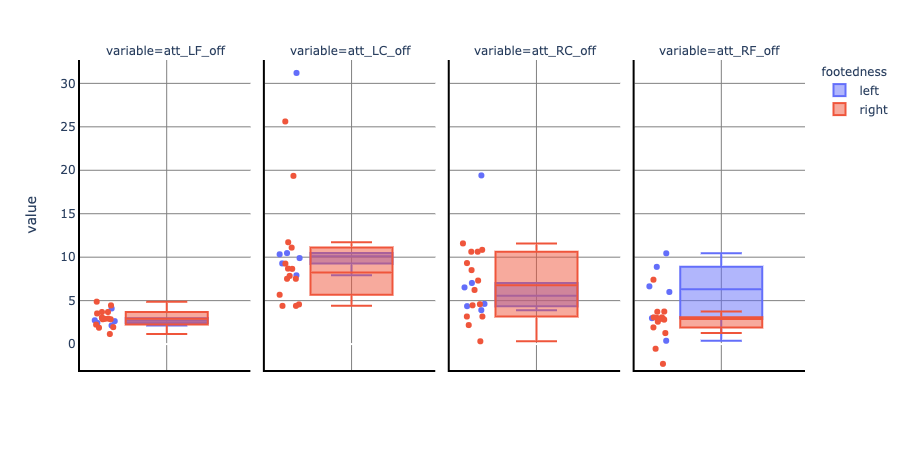

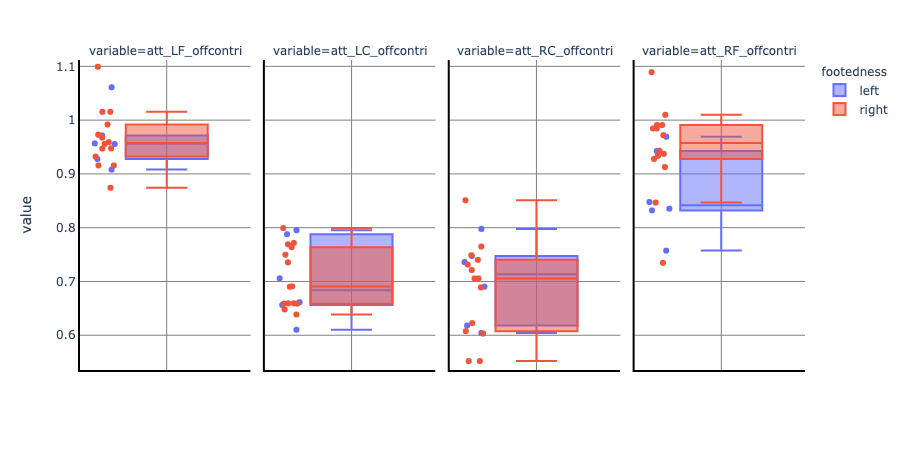

In [65]:
get_plots(df_lcb_ind_best)

In [66]:
df_rcb_ind = df_defenders_ind_att[df_defenders_ind_att['position'].isin(['R_CB','RCB'])]

In [67]:
df_rcb_ind_best = df_rcb_ind[df_rcb_ind['off_val_opp_avg']>=median(df_rcb_ind['off_val_opp_avg'].tolist())]

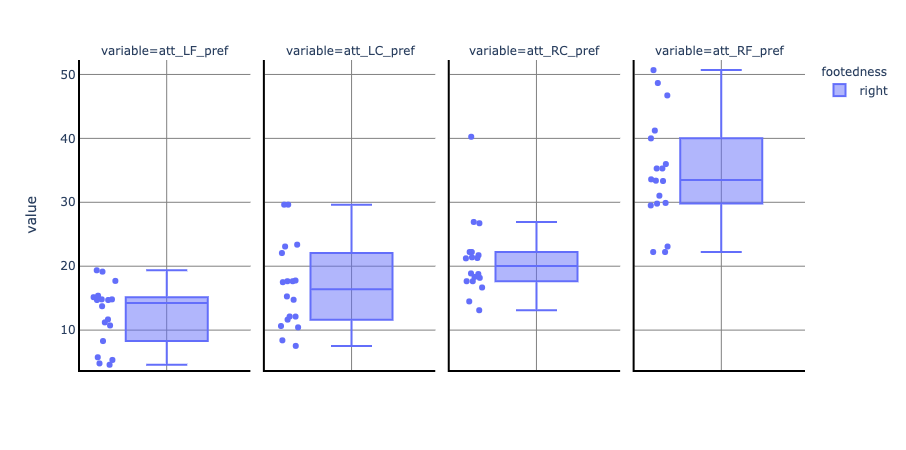

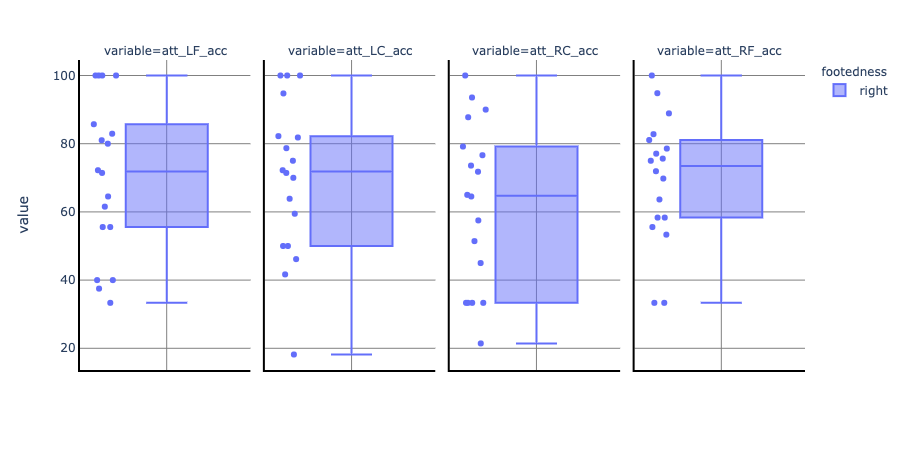

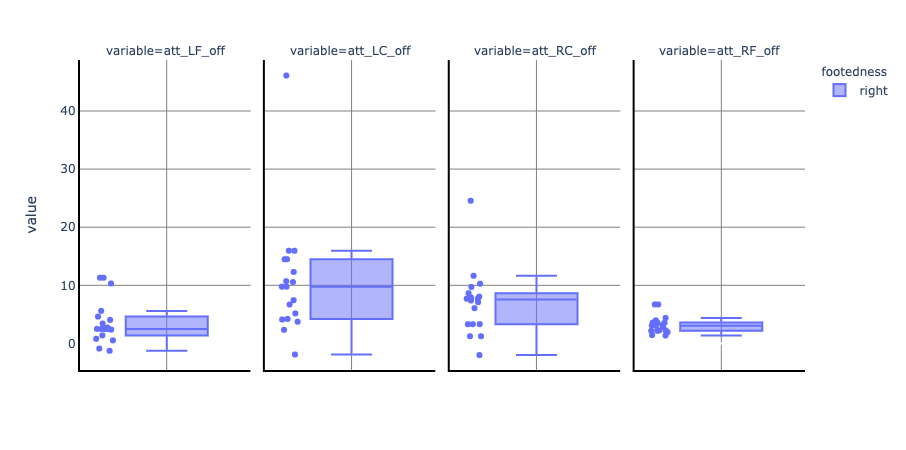

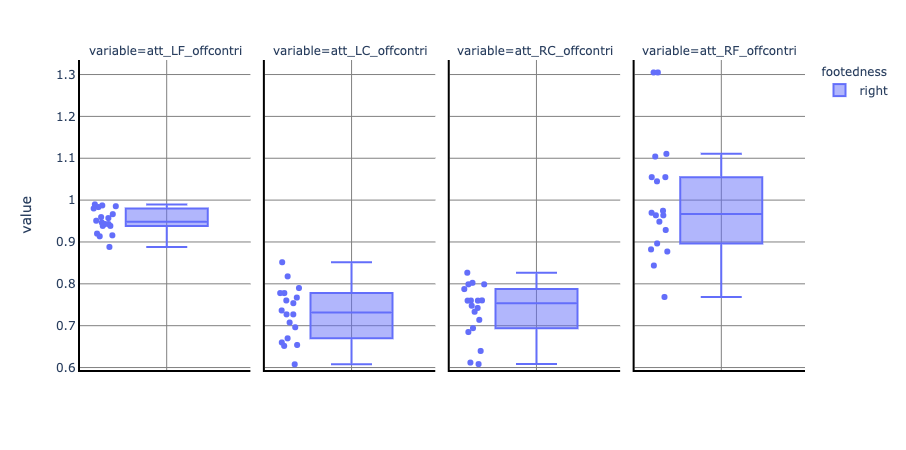

In [68]:
get_plots(df_rcb_ind_best)

In [69]:
df_rb_ind = df_defenders_ind_att[df_defenders_ind_att['position'].isin(['RB'])]

In [70]:
df_rb_ind_best = df_rb_ind[df_rb_ind['off_val_opp_avg']>=median(df_rb_ind['off_val_opp_avg'].tolist())]

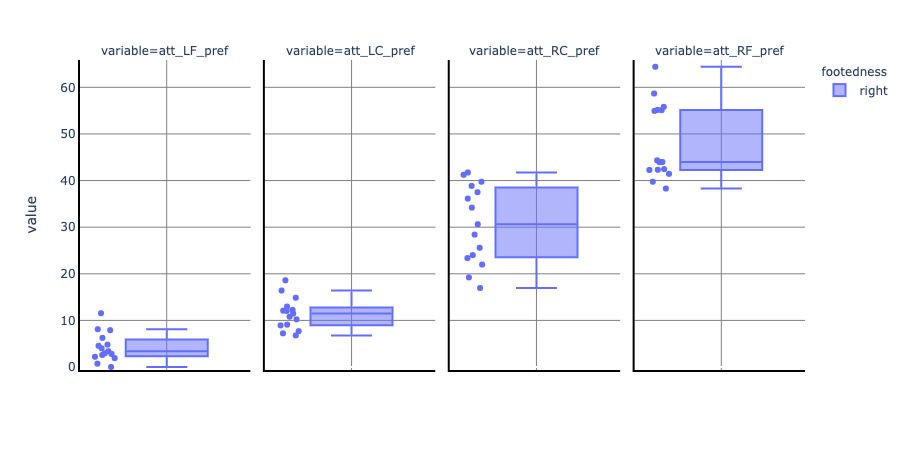

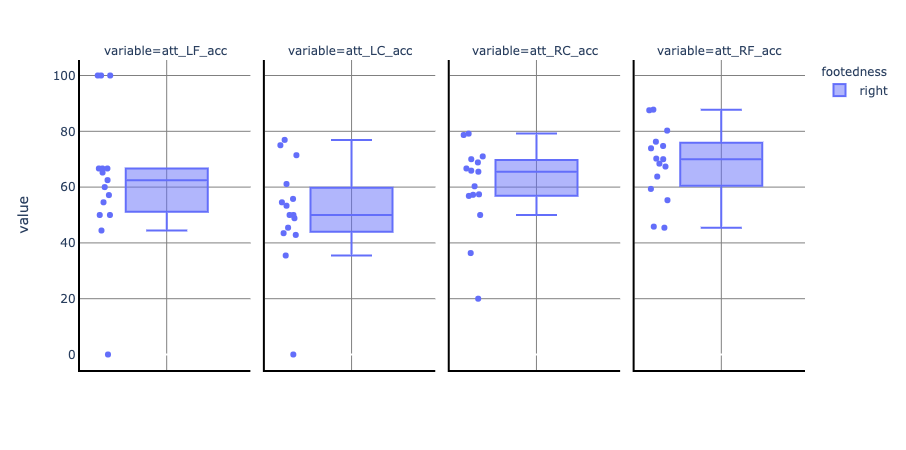

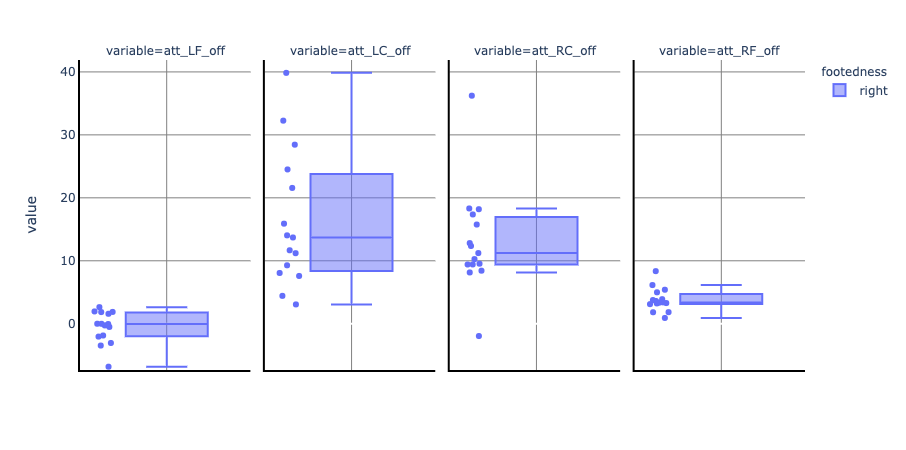

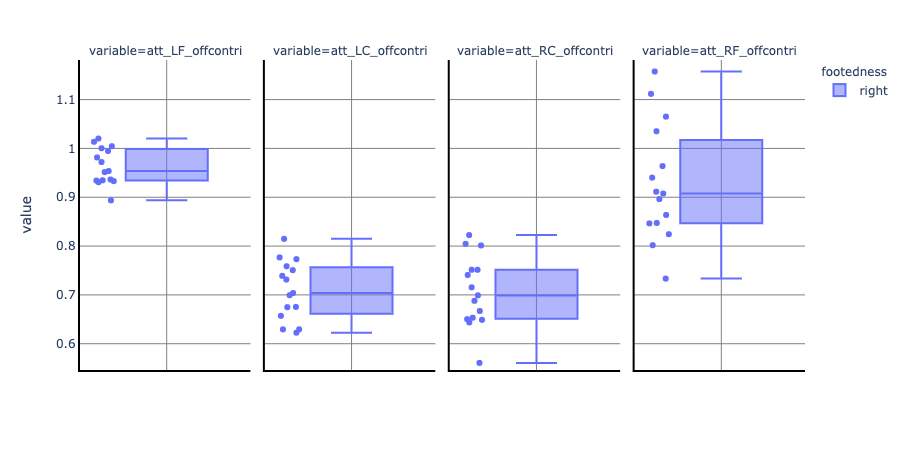

In [71]:
get_plots(df_rb_ind_best)

In [72]:
df_cb_ind = df_defenders_ind_att[df_defenders_ind_att['position'].isin(['CB'])]

In [73]:
df_cb_ind_best = df_cb_ind[df_cb_ind['off_val_opp_avg']>=median(df_cb_ind['off_val_opp_avg'].tolist())]

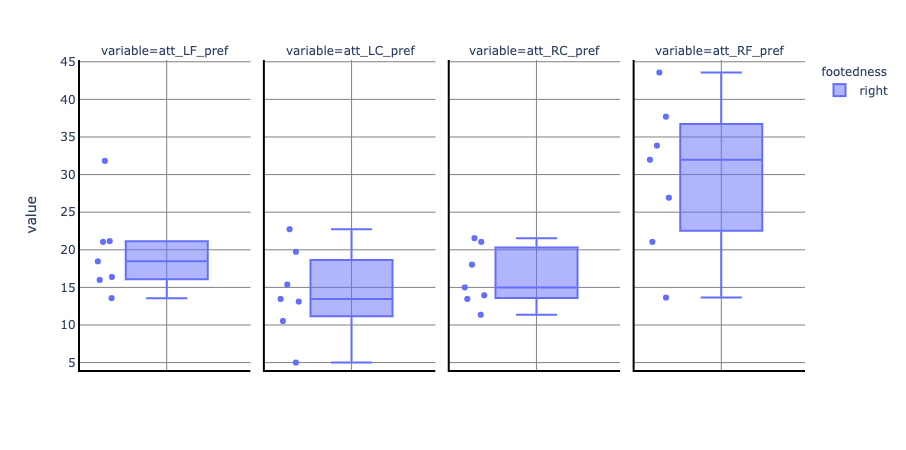

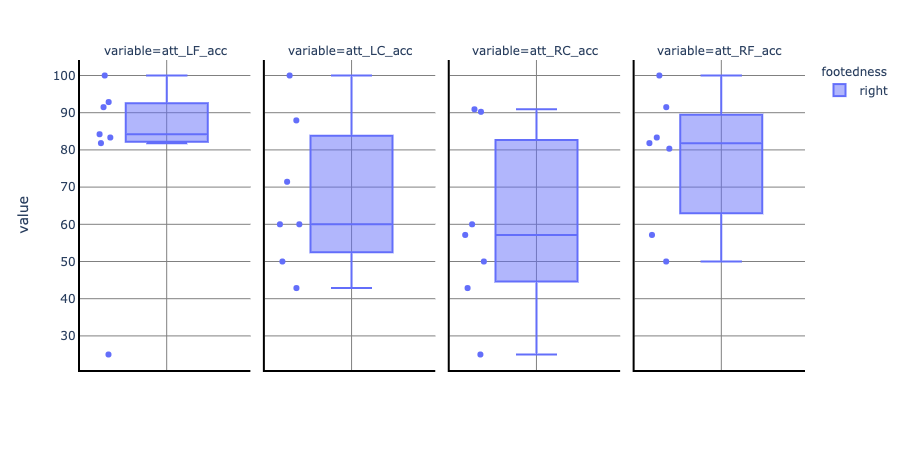

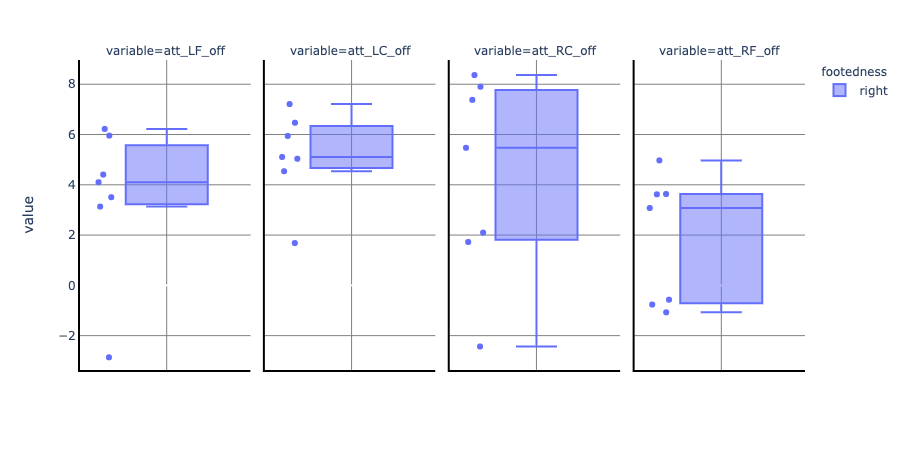

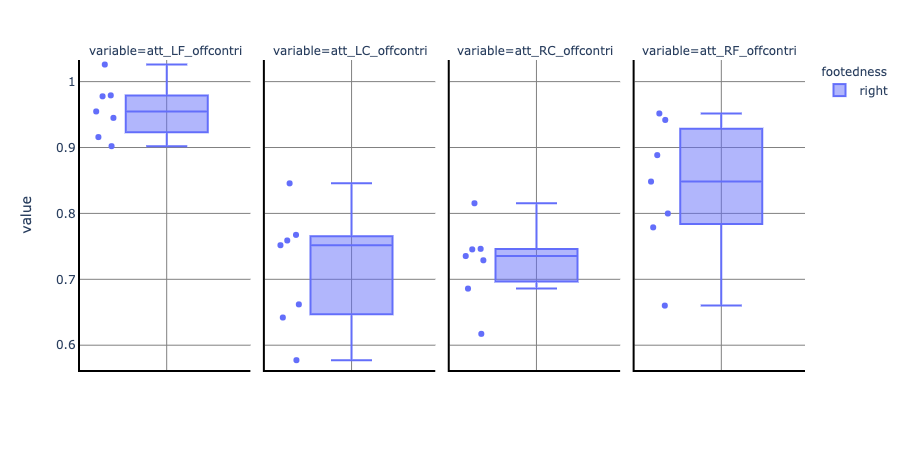

In [74]:
get_plots(df_cb_ind_best)